In [1]:
import pandas as pd
import numpy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [2]:
matches_df = pd.read_csv('Datasets/feature_dataset.csv')
# matches_df.drop(columns = ['Home XG','Away XG'],inplace=True)
matches_df.head()

,Season,Home Team,Away Team,Home Goals,Away Goals,Home Team ELO,Away Team ELO,Home XG,Away XG,Home XGA,Away XGA,Home Win Percentage,Home Draw Percentage,Away Win Percentage,Away Draw Percentage,Home Team Form,Away Team Form,Home Team Cumulative Points,Away Team Cumulative Points,Winner
0,2014-2015,Manchester Utd,Swansea City,1,2,1676,1521,54.21,33.84,40.90,55.94,64.50,20.64,29.82,28.95,0.0,0.0,0,0,-1
1,2014-2015,West Brom,Sunderland,2,2,1485,1520,38.63,37.45,53.75,51.46,24.01,26.97,26.52,25.10,0.0,0.0,0,0,0
2,2014-2015,Leicester City,Everton,2,2,1462,1692,48.21,44.89,56.39,46.18,27.27,29.22,36.44,28.54,0.0,0.0,0,0,0
3,2014-2015,West Ham,Tottenham,0,1,1509,1680,46.69,57.40,52.39,57.04,32.51,25.29,39.62,25.83,0.0,0.0,0,0,-1
4,2014-2015,QPR,Hull City,0,1,1420,1434,45.73,65.26,32.79,46.99,30.42,24.58,21.05,26.32,0.0,0.0,0,0,-1


In [3]:
def get_last_n_matches_form(team_name, df, n=5):
    # Filter matches where the team played either as home or away
    team_matches = df[(df['Home Team'] == team_name) | (df['Away Team'] == team_name)]
    
    # Sort by the index or a date column if available (here we use the index as a proxy for time)
    team_matches = team_matches.sort_index(ascending=False)
    
    # Get the last N matches
    last_n_matches = team_matches.head(n)
    
    # Calculate points for away matches
    away_points = list(last_n_matches[last_n_matches['Away Team'] == team_name]['Winner']).count(-1) * 3 + \
                  list(last_n_matches[last_n_matches['Away Team'] == team_name]['Winner']).count(0) * 1
    
    # Calculate points for home matches
    home_points = list(last_n_matches[last_n_matches['Home Team'] == team_name]['Winner']).count(1) * 3 + \
                  list(last_n_matches[last_n_matches['Home Team'] == team_name]['Winner']).count(0) * 1

    # Total points from the last N matches
    num_points = away_points + home_points
    # Form as a ratio of total points to the maximum possible points
    form = num_points / (n * 3)

    return form

team_names = list(set(matches_df['Home Team']))
print(get_last_n_matches_form('Arsenal',matches_df,n = 5))


1.0


In [5]:
#Setting team form for every team
# Function to add form columns to the entire DataFrame
def add_team_form_columns(df, n=5):
    # Initialize columns for home and away form
    df['Home Team Form'] = 0.0
    df['Away Team Form'] = 0.0
    
    # Iterate over each match in chronological order
    for i in range(len(df)):
        # Get a slice of the DataFrame up to the current match
        current_df = df.iloc[:i]
        
        # Get the home and away team names for the current match
        home_team = df.iloc[i]['Home Team']
        away_team = df.iloc[i]['Away Team']
        
        # Calculate the form for the home and away teams based on the last N matches
        home_team_form = get_last_n_matches_form(home_team, current_df, n)
        away_team_form = get_last_n_matches_form(away_team, current_df, n)
        
        # Update the form columns for the current match
        df.at[i, 'Home Team Form'] = home_team_form
        df.at[i, 'Away Team Form'] = away_team_form
    
    return df

def calculate_cumulative_points_multiple_seasons(df):
    # Initialize dictionaries to keep track of each team's points for each season
    team_points = {}
    
    # Create new columns for cumulative points for the home and away teams
    df['Home Team Cumulative Points'] = 0
    df['Away Team Cumulative Points'] = 0
    
    # Iterate over each row of the DataFrame in the original order
    for i in range(len(df)):
        # Get the season, home team, and away team for the current match
        season = df.iloc[i]['Season']
        home_team = df.iloc[i]['Home Team']
        away_team = df.iloc[i]['Away Team']
        
        # Initialize team points for the current season if not already done
        if season not in team_points:
            team_points[season] = {team: 0 for team in pd.concat([df['Home Team'], df['Away Team']]).unique()}
        
        # Get the current cumulative points for each team before the match
        df.at[i, 'Home Team Cumulative Points'] = team_points[season][home_team]
        df.at[i, 'Away Team Cumulative Points'] = team_points[season][away_team]
        
        # Update the points based on the match outcome
        if df.iloc[i]['Winner'] == 1:  # Home win
            team_points[season][home_team] += 3
        elif df.iloc[i]['Winner'] == -1:  # Away win
            team_points[season][away_team] += 3
        elif df.iloc[i]['Winner'] == 0:  # Draw
            team_points[season][home_team] += 1
            team_points[season][away_team] += 1

    return df
from collections import deque

def calculate_head_to_head(df, n=5):
    # Create dictionaries to keep track of recent H2H stats using a deque (to maintain the last N results)
    h2h_results = {}
    
    # Initialize new columns for recent H2H wins, draws, and losses for the home team
    df['Recent Home Team H2H Wins'] = 0
    df['Recent Home Team H2H Draws'] = 0
    df['Recent Home Team H2H Losses'] = 0

    # Iterate over each row in the dataframe
    for i, row in df.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        result = row['Winner']
        
        # Initialize nested deque if teams haven't played before
        if home_team not in h2h_results:
            h2h_results[home_team] = {}
        
        if away_team not in h2h_results[home_team]:
            h2h_results[home_team][away_team] = deque(maxlen=n)
        
        # Get the recent results deque for the home vs away encounter
        recent_results = h2h_results[home_team][away_team]

        # Count the recent wins, draws, and losses from the deque
        recent_wins = recent_results.count(1)
        recent_draws = recent_results.count(0)
        recent_losses = recent_results.count(-1)
        
        # Update the DataFrame with the counts of recent H2H results
        df.at[i, 'Recent Home Team H2H Wins'] = recent_wins
        df.at[i, 'Recent Home Team H2H Draws'] = recent_draws
        df.at[i, 'Recent Home Team H2H Losses'] = recent_losses

        # Update the deque with the current match result
        recent_results.append(result)

    return df






# def calculate_average_goals(df):
#     # Create dictionaries to keep track of total goals scored, conceded, and number of matches played
#     total_goals_scored = {}
#     total_goals_conceded = {}
#     num_matches_played = {}
    
#     # Initialize new columns for average goals scored and conceded
#     df['Home Team Avg Goals Scored'] = 0.0
#     df['Home Team Avg Goals Conceded'] = 0.0
#     df['Away Team Avg Goals Scored'] = 0.0
#     df['Away Team Avg Goals Conceded'] = 0.0

#     # Iterate over each row in the dataframe
#     for i, row in df.iterrows():
#         home_team = row['Home Team']
#         away_team = row['Away Team']
#         home_goals = row['Home Goals']
#         away_goals = row['Away Goals']
        
#         # Initialize values if the team has not been encountered yet
#         if home_team not in total_goals_scored:
#             total_goals_scored[home_team] = 0
#             total_goals_conceded[home_team] = 0
#             num_matches_played[home_team] = 0
        
#         if away_team not in total_goals_scored:
#             total_goals_scored[away_team] = 0
#             total_goals_conceded[away_team] = 0
#             num_matches_played[away_team] = 0
        
#         # Calculate the average goals scored and conceded for both teams up to the current match
#         if num_matches_played[home_team] > 0:
#             df.at[i, 'Home Team Avg Goals Scored'] = total_goals_scored[home_team] / num_matches_played[home_team]
#             df.at[i, 'Home Team Avg Goals Conceded'] = total_goals_conceded[home_team] / num_matches_played[home_team]
        
#         if num_matches_played[away_team] > 0:
#             df.at[i, 'Away Team Avg Goals Scored'] = total_goals_scored[away_team] / num_matches_played[away_team]
#             df.at[i, 'Away Team Avg Goals Conceded'] = total_goals_conceded[away_team] / num_matches_played[away_team]
        
#         # Update the total goals scored and conceded
#         total_goals_scored[home_team] += home_goals
#         total_goals_conceded[home_team] += away_goals
#         total_goals_scored[away_team] += away_goals
#         total_goals_conceded[away_team] += home_goals
        
#         # Increment the number of matches played for each team
#         num_matches_played[home_team] += 1
#         num_matches_played[away_team] += 1

#     return df

matches_df = add_team_form_columns(matches_df)
matches_df = calculate_cumulative_points_multiple_seasons(matches_df)
# matches_df = calculate_head_to_head(matches_df)
# matches_df = calculate_average_goals(matches_df)
matches_df.head()

matches_df.to_csv('final_feature_dataset.csv', index=False)

In [5]:
X = matches_df.drop(columns = ['Winner','Season','Home Team','Away Team','Home Goals','Away Goals'], axis=1)
# X = matches_df[['Home XGA','Away XGA','Home Team ELO','Away Team ELO','Home Team Form','Away Team Form']]
y = matches_df['Winner']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_regression_model = LogisticRegression(random_state=16, max_iter=10000, solver='saga')

logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Index(['Home Team ELO', 'Away Team ELO', 'Home XG', 'Away XG', 'Home XGA',
       'Away XGA', 'Home Win Percentage', 'Home Draw Percentage',
       'Away Win Percentage', 'Away Draw Percentage', 'Home Team Form',
       'Away Team Form', 'Home Team Cumulative Points',
       'Away Team Cumulative Points'],
      dtype='object')
Accuracy: 0.5855263157894737


Random Forest Accuracy: 0.7157894736842105
Random Forest F1 Score: 0.7156253763876458
Random Forest MSE: 0.9078947368421053
Random Forest R² Score: -0.18516241742396655
Correct Home Wins Predicted %: 0.797752808988764
Correct Away Wins Predicted %: 0.5925925925925926
Correct Draws Predicted %: 0.7204968944099379

Random Forest Feature Importances:
                        Feature  Importance
3                       Away XG    0.127522
4                      Home XGA    0.126752
1                 Away Team ELO    0.085751
0                 Home Team ELO    0.079988
8           Away Win Percentage    0.076484
6           Home Win Percentage    0.072897
2                       Home XG    0.071216
5                      Away XGA    0.068453
7          Home Draw Percentage    0.058783
9          Away Draw Percentage    0.058700
12  Home Team Cumulative Points    0.049374
13  Away Team Cumulative Points    0.048686
10               Home Team Form    0.038004
11               Away Team Form   

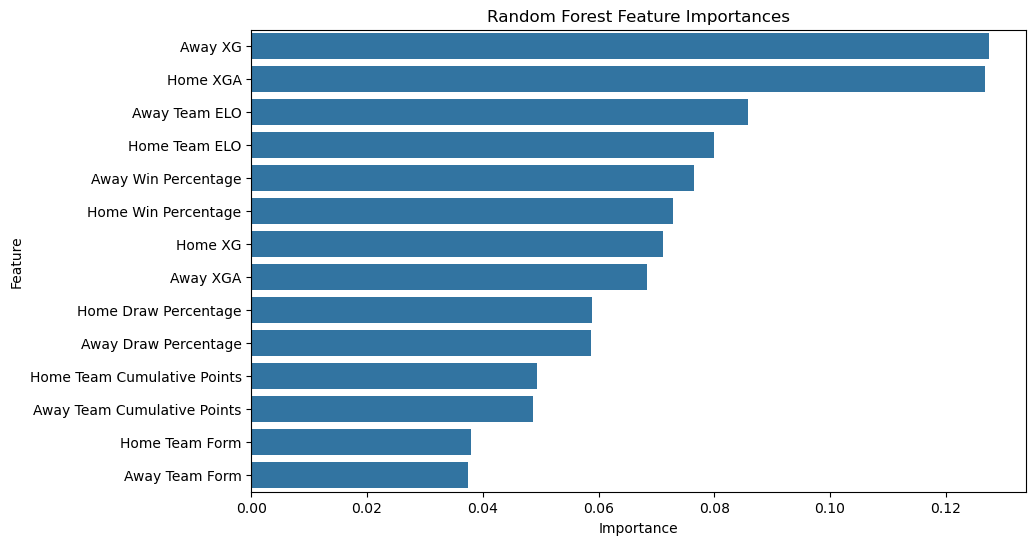

[[144   6  93]
 [ 21 116  24]
 [ 65   7 284]]


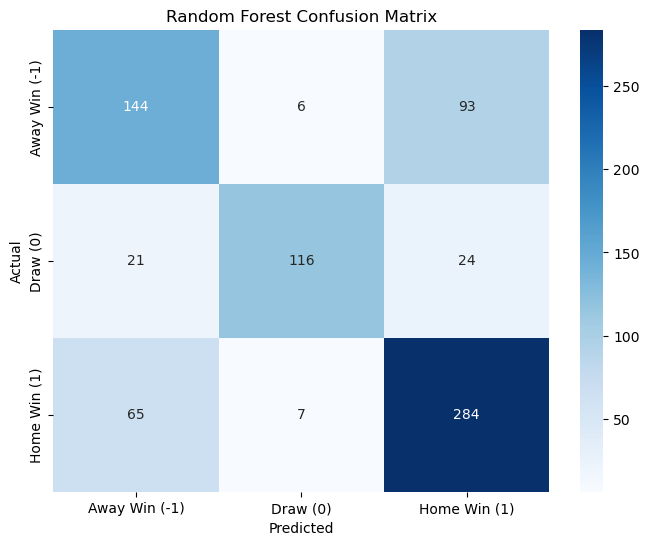

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

random_forest_model = RandomForestClassifier(random_state=16, n_estimators=1500)

random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy:', accuracy_rf)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print('Random Forest F1 Score:', f1_rf)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print('Random Forest MSE:', mse_rf)

# Calculate R² Score
r2_rf = r2_score(y_test, y_pred_rf)
print('Random Forest R² Score:', r2_rf)


correct_home_wins = sum((y_test == 1) & (y_pred_rf == 1)) /  sum(y_test == 1)
print('Correct Home Wins Predicted %:', correct_home_wins )

correct_away_wins = sum((y_test == -1) & (y_pred_rf == -1)) / sum(y_test == -1)
print('Correct Away Wins Predicted %:', correct_away_wins)

correct_draws = sum((y_test == 0) & (y_pred_rf == 0)) / sum(y_test == 0)
print('Correct Draws Predicted %:', correct_draws)

# Get feature importances
feature_importances_rf = random_forest_model.feature_importances_
features = X.columns

# Display feature importances
importance_df_rf = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_rf
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(importance_df_rf)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Random Forest Feature Importances')
plt.show()

cnf_matrix_rf =confusion_matrix(y_test, y_pred_rf)
print(cnf_matrix_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'], 
            yticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

SVM Accuracy: 0.5697368421052632
SVM F1 Score: 0.49587507258681135
SVM MSE: 1.0855263157894737
SVM R² Score: -0.4170420208330037
Correct Home Wins Predicted % (SVM): 0.8539325842696629
Correct Away Wins Predicted % (SVM): 0.5308641975308642
Correct Draws Predicted % (SVM): 0.0
[[129   0 114]
 [ 46   0 115]
 [ 52   0 304]]


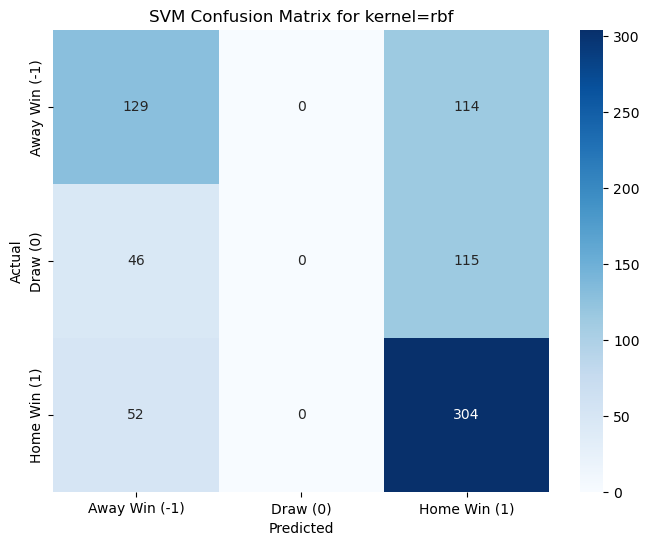

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

svm_model = SVC(kernel='rbf', random_state=16, decision_function_shape='ovr') 

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('SVM Accuracy:', accuracy_svm)

f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print('SVM F1 Score:', f1_svm)

mse_svm = mean_squared_error(y_test, y_pred_svm)
print('SVM MSE:', mse_svm)

r2_svm = r2_score(y_test, y_pred_svm)
print('SVM R² Score:', r2_svm)

correct_home_wins_svm = sum((y_test == 1) & (y_pred_svm == 1)) / sum(y_test == 1)
print('Correct Home Wins Predicted % (SVM):', correct_home_wins_svm)

correct_away_wins_svm = sum((y_test == -1) & (y_pred_svm == -1)) / sum(y_test == -1)
print('Correct Away Wins Predicted % (SVM):', correct_away_wins_svm)

correct_draws_svm = sum((y_test == 0) & (y_pred_svm == 0)) / sum(y_test == 0)
print('Correct Draws Predicted % (SVM):', correct_draws_svm)

cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(cnf_matrix_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'], 
            yticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix for kernel=rbf')
plt.show()

Logistic Regression Accuracy: 0.5434210526315789
Logistic Regression F1 Score: 0.5479468959445182
Logistic Regression MSE: 0.875
Logistic Regression R² Score: -0.1422217501259968
Correct Home Wins Predicted % (Logistic Regression): 0.598314606741573
Correct Away Wins Predicted % (Logistic Regression): 0.6296296296296297
Correct Draws Predicted % (Logistic Regression): 0.2919254658385093
Confusion Matrix (Logistic Regression):
[[153  48  42]
 [ 63  47  51]
 [ 64  79 213]]


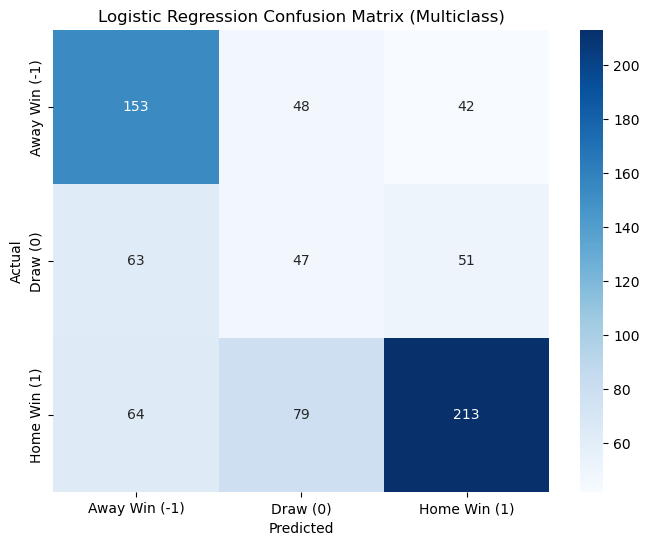

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

          -1       0.55      0.63      0.59       243
           0       0.27      0.29      0.28       161
           1       0.70      0.60      0.64       356

    accuracy                           0.54       760
   macro avg       0.50      0.51      0.50       760
weighted avg       0.56      0.54      0.55       760



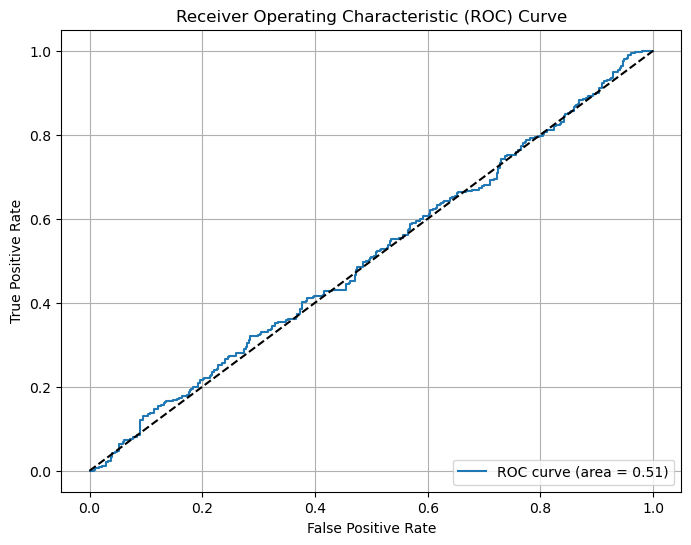

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

logistic_model = LogisticRegression(multi_class='multinomial', solver='saga', random_state=16, class_weight='balanced', max_iter=10000)

logistic_model.fit(X_train, y_train)

y_pred_log = logistic_model.predict(X_test)

accuracy_log = accuracy_score(y_test, y_pred_log)
print('Logistic Regression Accuracy:', accuracy_log)

f1_log = f1_score(y_test, y_pred_log, average='weighted')
print('Logistic Regression F1 Score:', f1_log)

mse_log = mean_squared_error(y_test, y_pred_log)
print('Logistic Regression MSE:', mse_log)

r2_log = r2_score(y_test, y_pred_log)
print('Logistic Regression R² Score:', r2_log)

correct_home_wins_log = sum((y_test == 1) & (y_pred_log == 1)) / sum(y_test == 1)
print('Correct Home Wins Predicted % (Logistic Regression):', correct_home_wins_log)

correct_away_wins_log = sum((y_test == -1) & (y_pred_log == -1)) / sum(y_test == -1)
print('Correct Away Wins Predicted % (Logistic Regression):', correct_away_wins_log)

correct_draws_log = sum((y_test == 0) & (y_pred_log == 0)) / sum(y_test == 0)
print('Correct Draws Predicted % (Logistic Regression):', correct_draws_log)

cnf_matrix_log = confusion_matrix(y_test, y_pred_log)
print('Confusion Matrix (Logistic Regression):')
print(cnf_matrix_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'], 
            yticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix (Multiclass)')
plt.show()

print('Classification Report (Logistic Regression):')
print(classification_report(y_test, y_pred_log))

from sklearn.metrics import roc_curve, auc

y_test_proba = logistic_model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test == 1, y_test_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Decision Tree Accuracy: 0.6157894736842106
Decision Tree F1 Score: 0.6164494696984801
Decision Tree MSE: 1.1460526315789474
Decision Tree R² Score: -0.4960528486612681
Correct Home Wins Predicted % (Decision Tree): 0.6207865168539326
Correct Away Wins Predicted % (Decision Tree): 0.5432098765432098
Correct Draws Predicted % (Decision Tree): 0.7142857142857143
[[132  20  91]
 [ 22 115  24]
 [102  33 221]]


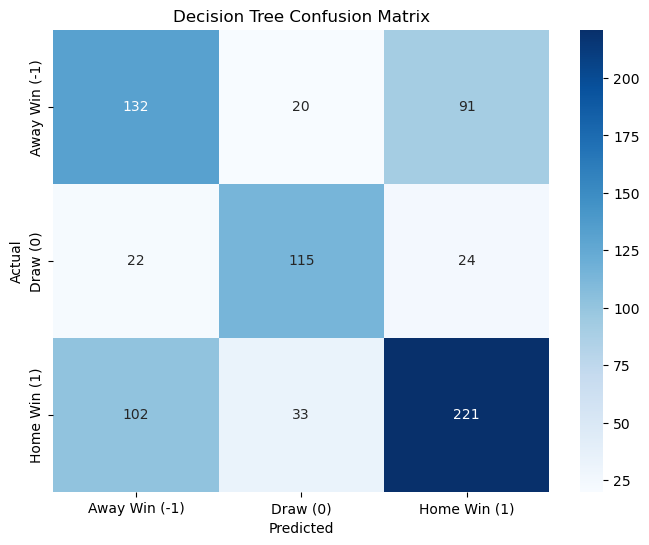


Decision Tree Feature Importances:
                        Feature  Importance
3                       Away XG    0.158508
4                      Home XGA    0.149633
0                 Home Team ELO    0.099598
1                 Away Team ELO    0.099332
5                      Away XGA    0.075883
8           Away Win Percentage    0.061770
7          Home Draw Percentage    0.059104
9          Away Draw Percentage    0.057060
2                       Home XG    0.051082
6           Home Win Percentage    0.046515
13  Away Team Cumulative Points    0.045520
12  Home Team Cumulative Points    0.042486
11               Away Team Form    0.028601
10               Home Team Form    0.024907


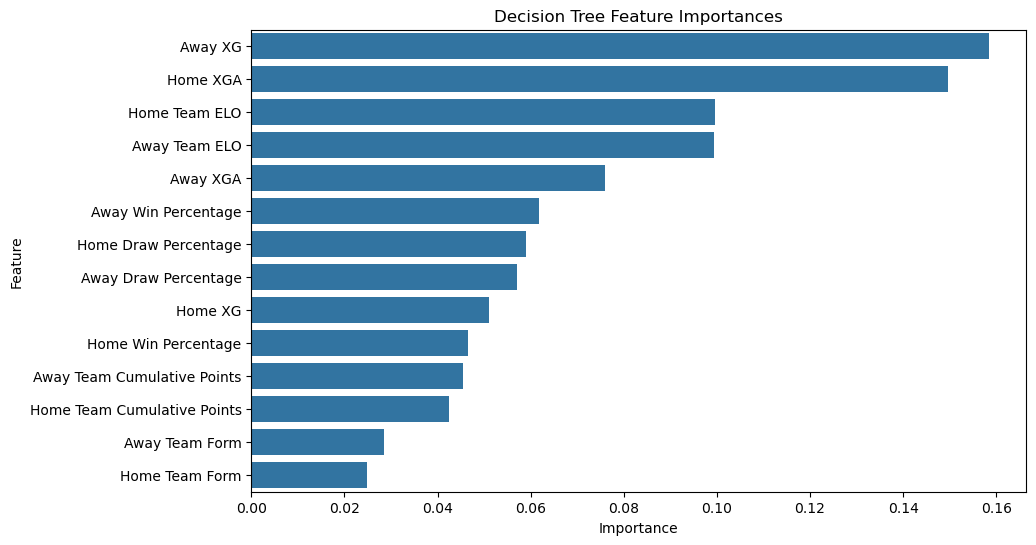

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


dt_model = DecisionTreeClassifier(random_state=16)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy:', accuracy_dt)

f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
print('Decision Tree F1 Score:', f1_dt)

mse_dt = mean_squared_error(y_test, y_pred_dt)
print('Decision Tree MSE:', mse_dt)

r2_dt = r2_score(y_test, y_pred_dt)
print('Decision Tree R² Score:', r2_dt)

correct_home_wins_dt = sum((y_test == 1) & (y_pred_dt == 1)) / sum(y_test == 1)
print('Correct Home Wins Predicted % (Decision Tree):', correct_home_wins_dt)

correct_away_wins_dt = sum((y_test == -1) & (y_pred_dt == -1)) / sum(y_test == -1)
print('Correct Away Wins Predicted % (Decision Tree):', correct_away_wins_dt)

correct_draws_dt = sum((y_test == 0) & (y_pred_dt == 0)) / sum(y_test == 0)
print('Correct Draws Predicted % (Decision Tree):', correct_draws_dt)

cnf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(cnf_matrix_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'], 
            yticklabels=['Away Win (-1)', 'Draw (0)', 'Home Win (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

feature_importances_dt = dt_model.feature_importances_
features = X_train.columns

importance_df_dt = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances_dt
}).sort_values(by='Importance', ascending=False)

print("\nDecision Tree Feature Importances:")
print(importance_df_dt)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_dt)
plt.title('Decision Tree Feature Importances')
plt.show()